In [337]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import keras_tuner
import cv2
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.callbacks import TensorBoard

## Preprocess data

In [299]:
df = pd.read_csv("labels.csv")
def concat_list(df,cap,num):
    num = num-1
    df['label_cnt'] = df.groupby('label')['label'].transform('count')
    con = df.query(f"label_cnt <= {cap}")
    for i in range(num):
        df = pd.concat([con,df],ignore_index=True)
    return df
df = concat_list(df,6,4)
df = concat_list(df,8,3)
df = concat_list(df,12,2)

print(type(df.label[0]))
print(df['label'].value_counts())

<class 'str'>
[0 1 0 0 1 0 1 0 0 0 0 0 0]    24
[0 0 0 0 1 0 1 0 0 0 0 0 0]    24
[0 0 0 1 0 0 0 0 0 0 1 0 0]    24
[1 0 0 1 0 0 0 0 0 0 0 0 0]    24
[1 0 0 0 0 0 0 0 0 0 0 0 0]    24
[0 0 0 1 1 0 1 0 0 0 0 0 0]    24
[0 0 0 1 0 0 0 0 0 1 0 0 0]    24
[0 0 0 0 1 0 0 0 0 0 0 0 0]    24
[1 1 0 0 0 1 0 0 0 0 0 0 0]    24
[0 1 0 0 0 1 1 1 0 0 0 0 0]    24
[0 1 0 0 0 0 0 0 1 0 0 0 0]    24
[0 1 0 0 0 1 1 0 0 0 0 0 0]    24
[0 1 0 0 0 0 0 0 1 1 0 0 0]    24
[0 1 1 0 0 1 0 0 0 0 1 0 0]    24
[0 1 0 0 0 0 0 0 0 0 0 1 0]    24
[0 0 1 1 0 0 1 0 0 0 0 0 0]    24
[0 1 1 0 1 0 0 0 0 0 0 0 0]    24
[0 0 0 0 0 0 0 0 0 0 0 0 1]    24
[0 0 0 1 0 0 0 0 1 0 0 0 0]    24
[0 1 1 0 0 1 0 0 0 0 0 0 0]    24
[0 0 0 1 1 0 0 0 0 0 0 0 0]    24
[1 1 0 0 0 0 0 0 1 0 0 0 0]    24
[0 1 0 0 1 1 1 0 0 0 0 0 0]    24
[0 1 0 0 0 0 0 0 0 1 0 0 0]    24
[0 0 1 0 0 0 0 0 0 0 1 0 0]    24
[0 0 1 0 0 1 0 0 0 0 1 0 0]    24
[0 0 1 0 0 0 0 0 1 0 0 0 0]    24
[1 0 0 1 0 0 0 0 0 1 0 0 0]    24
[1 0 0 0 0 0 0 0 0 1 0 0 0]    24


In [300]:
def string2list(x):
    return [int(y) for y in x[1:-1].split(" ")]
def preprocess_data(df):
    label_dir = "./dataset/labeled/"
    df["images"] = df["imageID"].apply(lambda x : cv2.imread(f"{label_dir}{x}.png",0))
    df["label"] = df["label"].apply(string2list)
    df = df.sample(frac=1)
    excluded_label = [[0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0]]
    test_base = df.query("label == @excluded_label")
    train_base = df.query("label != @excluded_label")
    x_train = np.stack(train_base["images"].values)
    x_test = np.stack(test_base["images"].values)
    y_train = np.stack(train_base["label"].values)
    y_test = np.stack(test_base["label"].values) # np.array([np.array(y) for y in test_base["label"]])
    print(x_train.shape)
    return (x_train,y_train),(x_test,y_test)

# df = pd.read_csv("labels.csv")        
(x_train, y_train), (x_test, y_test) = preprocess_data(df)

(1199, 100, 100)


## train template

In [301]:
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
print(x_test.shape)

(24, 100, 100, 1)


In [338]:
def build_model(hp):
    model = keras.Sequential(
        [
            keras.Input(shape=input_shape),
            layers.Conv2D(hp.Choice('units', [32, 64, 128]), kernel_size=(3, 3), activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Conv2D(hp.Choice('units', [32, 64, 128]), kernel_size=(3, 3), activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Flatten(),
            layers.Dropout(0.5),
            layers.Dense(num_classes, activation="sigmoid"),
        ]
    )
    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
    return model

# model = model_builder()
# model.summary()

In [339]:
tuner = keras_tuner.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5)

tuner.search(x_train, y_train, epochs=5, validation_data=(x_test, y_test))
best_model = tuner.get_best_models()[0]

INFO:tensorflow:Reloading Tuner from ./untitled_project/tuner0.json


KeyError: <keras_tuner.engine.trial.Trial object at 0x7f6288a0b580>

In [315]:
batch_size = 32
epochs = 5
NAME = "base-cnn"
tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

# model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

model.fit(x_train, y_train, batch_size=Epoch 2/5
batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/5
34/34 [==============================] - 23s 639ms/step - loss: 0.1904 - accuracy: 0.3994 - val_loss: 0.0079 - val_accuracy: 0.4833
Epoch 2/5
34/34 [==============================] - 22s 651ms/step - loss: 0.0385 - accuracy: 0.4690 - val_loss: 0.0040 - val_accuracy: 0.3917
Epoch 3/5
34/34 [==============================] - 25s 747ms/step - loss: 0.0306 - accuracy: 0.4337 - val_loss: 0.0025 - val_accuracy: 0.3750
Epoch 4/5
34/34 [==============================] - 21s 618ms/step - loss: 0.0236 - accuracy: 0.4347 - val_loss: 0.0019 - val_accuracy: 0.3333
Epoch 5/5
34/34 [==============================] - 21s 623ms/step - loss: 0.0231 - accuracy: 0.4310 - val_loss: 0.0011 - val_accuracy: 0.3500


In [304]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.09054438024759293
Test accuracy: 1.0


1/1 [==============================] - 0s 94ms/step
[4.4147480e-08 9.9999982e-01 2.2066058e-09 1.7912886e-06 1.9180487e-05
 9.9913305e-01 2.2684206e-01 9.5209014e-01 5.0483191e-06 5.4227212e-06
 7.4930988e-08 6.1073891e-08 3.9984371e-09]
[0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0]
[0 1 0 0 0 1 1 1 0 0 0 0 0]


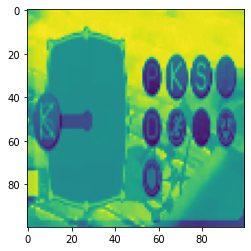

In [307]:
plt.imshow(x_test[0])
predictions = model.predict([x_test])
print(predictions[1])
print([1 if x > 0.5 else 0 for x in predictions[1]])
print(y_test[1])

## Train Machine

(205, 100, 100)
x_train shape: (205, 100, 100)
205 train samples
2 test samples


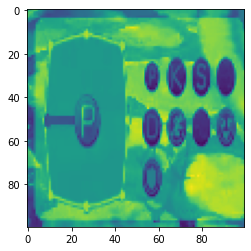

In [173]:
# Model / data parameters
num_classes = 13
input_shape = (100, 100, 1)

# Load the data and split it between train and test sets
df = pd.read_csv("labels.csv")        
(x_train, y_train), (x_test, y_test) = preprocess_data(df)

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
# reshape to write input shape
# x_train = np.array([cv2.cvtColor(cv2.resize(x, input_shape[:2], 
#                                             interpolation = cv2.INTER_AREA),cv2.COLOR_GRAY2RGB) for x in x_train])
# x_test = np.array([cv2.cvtColor(cv2.resize(x, input_shape[:2], 
#                                            interpolation = cv2.INTER_AREA),cv2.COLOR_GRAY2RGB) for x in x_test])

# x_train = np.array([cv2.resize(x, input_shape[:2], interpolation = cv2.INTER_AREA) for x in x_train])
# x_test = np.array([cv2.resize(x, input_shape[:2], interpolation = cv2.INTER_AREA) for x in x_test])

# Make sure images have shape (28, 28, 1)
# x_train = np.expand_dims(x_train, -1)
# x_test = np.expand_dims(x_test, -1)
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")
# preprocess input
plt.imshow(x_train[0])



# convert class vectors to binary class matrices
# y_train = keras.utils.to_categorical(y_train, num_classes)
# y_test = keras.utils.to_categorical(y_test, num_classes)

In [128]:
print(y_test.shape)
print(np.stack(x_test.values).shape)
# y_train2 = keras.utils.to_categorical(y_train, num_classes)

(2, 13)
(2, 100, 100, 3)


In [151]:
base_model = keras.applications.MobileNet(
    input_shape=input_shape,
    alpha=1.0,
    depth_multiplier=1,
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax"
)
base_model.trainable = False
base_model.layers.pop()
print(base_model.summary())

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 50, 50, 32)        864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 50, 50, 32)       128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 50, 50, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 50, 50, 32)       288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 50, 50, 32)       128       
 ation)                                         

                                                                 
 conv_pw_8 (Conv2D)          (None, 6, 6, 512)         262144    
                                                                 
 conv_pw_8_bn (BatchNormaliz  (None, 6, 6, 512)        2048      
 ation)                                                          
                                                                 
 conv_pw_8_relu (ReLU)       (None, 6, 6, 512)         0         
                                                                 
 conv_dw_9 (DepthwiseConv2D)  (None, 6, 6, 512)        4608      
                                                                 
 conv_dw_9_bn (BatchNormaliz  (None, 6, 6, 512)        2048      
 ation)                                                          
                                                                 
 conv_dw_9_relu (ReLU)       (None, 6, 6, 512)         0         
                                                                 
 conv_pw_9

In [152]:
def custom_augmentation(np_tensor):
 
  def random_crop(np_tensor):
 
    #cropped height between 70% to 130% of an original height
    new_height = int(np.random.uniform(0.7, 1.30) * np_tensor.shape[0])
 
    #cropped width between 70% to 130% of an original width
    new_width = int(np.random.uniform(0.7, 1.30) * np_tensor.shape[1])
 
    # resize to new height and width
    cropped = tf.image.resize_with_crop_or_pad(np_tensor, new_height, new_width)
 
    return tf.image.resize(cropped, np_tensor.shape[:2])
 
  augmnted_tensor = random_crop(np_tensor)
  return np.array(augmnted_tensor)

In [153]:
inputs = keras.Input(shape=input_shape)
# preprocess for mobile net
preprocessed_input = keras.applications.mobilenet_v2.preprocess_input(inputs)
base_outputs = base_model(preprocessed_input, training=False)
# Convert features of shape `base_model.output_shape[1:]` to vectors
x = keras.layers.GlobalAveragePooling2D()(base_outputs)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
# A Dense classifier with a single unit (binary classification)
outputs = keras.layers.Dense(num_classes,activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 tf.math.truediv_2 (TFOpLamb  (None, 100, 100, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_2 (TFOpLam  (None, 100, 100, 3)      0         
 bda)                                                            
                                                                 
 mobilenet_1.00_224 (Functio  (None, 3, 3, 1024)       3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d_2   (None, 1024)             0         
 (GlobalAveragePooling2D)                                  

In [154]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

model.fit(x_train, y_train, batch_size=32, epochs=5, validation_split=0.1)

Epoch 1/5
6/6 [==============================] - 5s 521ms/step - loss: 4.1334 - accuracy: 0.3424 - val_loss: 3.7057 - val_accuracy: 0.2857
Epoch 2/5
6/6 [==============================] - 2s 302ms/step - loss: 4.0630 - accuracy: 0.3424 - val_loss: 3.6580 - val_accuracy: 0.2857
Epoch 3/5
6/6 [==============================] - 2s 299ms/step - loss: 3.9934 - accuracy: 0.3533 - val_loss: 3.6197 - val_accuracy: 0.2857
Epoch 4/5
6/6 [==============================] - 2s 307ms/step - loss: 3.9374 - accuracy: 0.3478 - val_loss: 3.5900 - val_accuracy: 0.2857
Epoch 5/5
6/6 [==============================] - 2s 300ms/step - loss: 3.8867 - accuracy: 0.3533 - val_loss: 3.5668 - val_accuracy: 0.2857


In [155]:
base_model.trainable = True
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 tf.math.truediv_2 (TFOpLamb  (None, 100, 100, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_2 (TFOpLam  (None, 100, 100, 3)      0         
 bda)                                                            
                                                                 
 mobilenet_1.00_224 (Functio  (None, 3, 3, 1024)       3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d_2   (None, 1024)             0         
 (GlobalAveragePooling2D)                                  

In [156]:
model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
    loss="categorical_crossentropy", metrics=["accuracy"] # categorical_crossentropy
)

epochs = 10
model.fit(x_train, y_train, batch_size=32, epochs=epochs, validation_split=0.1)

Epoch 1/10
6/6 [==============================] - 17s 1s/step - loss: 3.8644 - accuracy: 0.3424 - val_loss: 3.8355 - val_accuracy: 0.2857
Epoch 2/10
6/6 [==============================] - 7s 1s/step - loss: 4.1785 - accuracy: 0.3533 - val_loss: 4.1393 - val_accuracy: 0.2857
Epoch 3/10
6/6 [==============================] - 9s 2s/step - loss: 4.2378 - accuracy: 0.2554 - val_loss: 4.2668 - val_accuracy: 0.2857
Epoch 4/10
6/6 [==============================] - 7s 1s/step - loss: 4.3415 - accuracy: 0.3207 - val_loss: 4.4529 - val_accuracy: 0.2857
Epoch 5/10
6/6 [==============================] - 7s 1s/step - loss: 4.6144 - accuracy: 0.2772 - val_loss: 4.3134 - val_accuracy: 0.2857
Epoch 6/10
6/6 [==============================] - 7s 1s/step - loss: 4.4565 - accuracy: 0.2663 - val_loss: 4.5120 - val_accuracy: 0.2857
Epoch 7/10
6/6 [==============================] - 7s 1s/step - loss: 4.6482 - accuracy: 0.2446 - val_loss: 4.6346 - val_accuracy: 0.2857
Epoch 8/10
6/6 [========================

In [147]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.21703127026557922
Test accuracy: 1.0


1/1 [==============================] - 1s 668ms/step


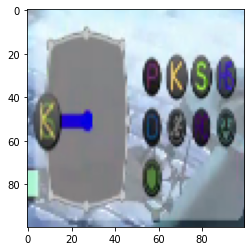

In [148]:
plt.imshow(x_test[0])
predictions = model.predict([x_test])


In [160]:
print(predictions[1]>0.5)
print(y_test[1] > 0)

[False  True False False False False False False False False False False
 False]
[False  True False False False  True  True  True False False False False
 False]
